In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

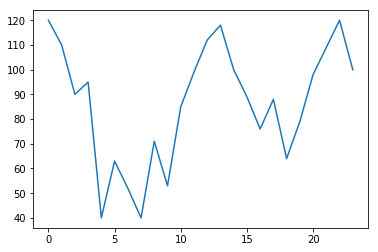

In [2]:
training_set = pd.read_csv('./input/mock-count.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Mock Data')
plt.show()

In [3]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 5
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [5]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.42918
Epoch: 100, loss: 0.06735
Epoch: 200, loss: 0.04244
Epoch: 300, loss: 0.03752
Epoch: 400, loss: 0.03557
Epoch: 500, loss: 0.03267
Epoch: 600, loss: 0.02473
Epoch: 700, loss: 0.01958
Epoch: 800, loss: 0.01710
Epoch: 900, loss: 0.01454
Epoch: 1000, loss: 0.00840
Epoch: 1100, loss: 0.00431
Epoch: 1200, loss: 0.00142
Epoch: 1300, loss: 0.00021
Epoch: 1400, loss: 0.00007
Epoch: 1500, loss: 0.00005
Epoch: 1600, loss: 0.00005
Epoch: 1700, loss: 0.00004
Epoch: 1800, loss: 0.00004
Epoch: 1900, loss: 0.00003


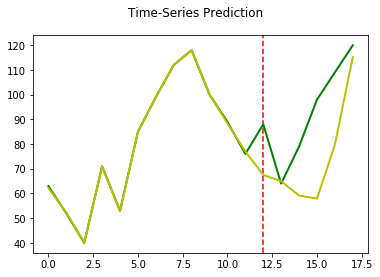

In [6]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, "g", label="real_values", linewidth=2.0)
plt.plot(data_predict, "y", label="prediction", linewidth=2.0)
plt.suptitle('Time-Series Prediction')
plt.show()

In [7]:
import pandas as pd
sales = pd.read_csv("./input/mock-count.csv")
df = sales.dropna()
print(sales)

X = df.index.factorize()[0].reshape(-1,1)
print("X: ", X)

y = sales["Count"].tolist()
print("y: ", y)

       Date  Count
0   2017-01    120
1   2017-02    110
2   2017-03     90
3   2017-04     95
4   2017-05     40
5   2017-06     63
6   2017-07     52
7   2017-08     40
8   2017-09     71
9   2017-10     53
10  2017-11     85
11  2017-12     99
12  2018-01    112
13  2018-02    118
14  2018-03    100
15  2018-04     89
16  2018-05     76
17  2018-06     88
18  2018-07     64
19  2018-08     79
20  2018-09     98
21  2018-10    109
22  2018-11    120
23  2018-12    100
X:  [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]]
y:  [120, 110, 90, 95, 40, 63, 52, 40, 71, 53, 85, 99, 112, 118, 100, 89, 76, 88, 64, 79, 98, 109, 120, 100]


In [35]:
def X_to_x_windows(X):
    seq_length = 2
    x = []
    y = []
    z = []

    for i in range(len(X)-seq_length-1):
        _x = X[i:(i+seq_length)]
        z.append(_x)
        
    for i in range(len(X)):
        x.append(X[i:(i+1)])
    
        
    for i in range(len(X) - 3):
        _x = X[i:(i+seq_length)]
        y.append(_x)
        
    print(x)
    print()
    print(y)
    print()
    print(z)
    return np.array(y)



lstm.eval()
tensorX = Variable(torch.Tensor(X_to_x_windows(X)))

train_predict = sc.inverse_transform(lstm(tensorX).data.numpy())

[array([[0]]), array([[1]]), array([[2]]), array([[3]]), array([[4]]), array([[5]]), array([[6]]), array([[7]]), array([[8]]), array([[9]]), array([[10]]), array([[11]]), array([[12]]), array([[13]]), array([[14]]), array([[15]]), array([[16]]), array([[17]]), array([[18]]), array([[19]]), array([[20]]), array([[21]]), array([[22]]), array([[23]])]

[array([[0],
       [1]]), array([[1],
       [2]]), array([[2],
       [3]]), array([[3],
       [4]]), array([[4],
       [5]]), array([[5],
       [6]]), array([[6],
       [7]]), array([[7],
       [8]]), array([[8],
       [9]]), array([[ 9],
       [10]]), array([[10],
       [11]]), array([[11],
       [12]]), array([[12],
       [13]]), array([[13],
       [14]]), array([[14],
       [15]]), array([[15],
       [16]]), array([[16],
       [17]]), array([[17],
       [18]]), array([[18],
       [19]]), array([[19],
       [20]]), array([[20],
       [21]])]

[array([[0],
       [1]]), array([[1],
       [2]]), array([[2],
       [3]]

[[172.25015]
 [186.64767]
 [173.21411]
 [158.67358]
 [152.32355]
 [150.20576]
 [149.58482]
 [149.42657]
 [149.39847]
 [149.40219]
 [149.41092]
 [149.41843]
 [149.42384]
 [149.42752]
 [149.43001]
 [149.43167]
 [149.4328 ]
 [149.43355]
 [149.43405]
 [149.43439]
 [149.43462]]


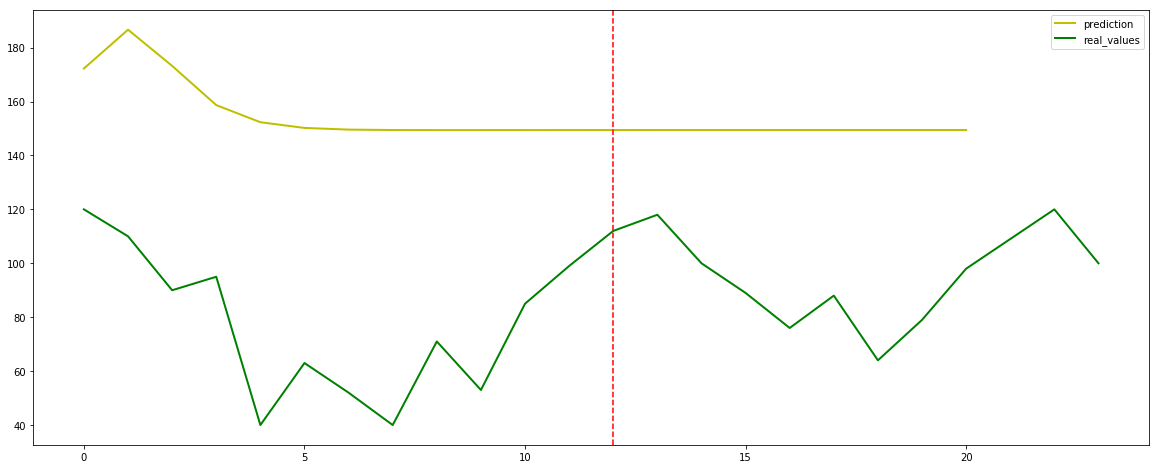

In [36]:
plt.figure(figsize=(20,8))
print(train_predict)
plt.plot(train_predict, "y", label="prediction", linewidth=2.0)
plt.plot(y, "g", label="real_values", linewidth=2.0)
plt.axvline(x=train_size, c='r', linestyle='--')
plt.legend(loc="best")
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, train_predict)
print("RMSE:", np.sqrt(mse))

RMSE: 50.73800610696495
